# Generate images for both human eyes and in silico

In [1]:
import function as df
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
import os
import bz2

In [11]:
SAMPLE      = ['SAMPLE','sample_ID']
CNV_CHR     = ['chr', 'CHR', 'CHROMOSOME', 'chromosome']
CNV_START   = ['cnv_start', 'start', 'PRED_START', 'START']
CNV_END     = ['cnv_stop', 'stop', 'PRED_END', 'END']
CNV_TYPE    = ['cnv_type','type','TYPE','CNV', 'CNV_TYPE']
NUM_TARGETS = ['NUM_TARGETS','targets']
CNV_LABEL   = ['LABEL_VAL','label','LABEL']

## Data files and folders

In [2]:
training_set_true_file  = '/home/rt2776/cnv_espresso/training_set/training_set_true.txt'
training_set_false_file = '/home/rt2776/cnv_espresso/training_set/training_set_false.txt'
RD_norm_dir             = '/home/rt2776/cnv_espresso/data/norm/'
ref_samples_dir         = '/home/rt2776/cnv_espresso/reference_samples/'
output_false_image_dir  = '/home/rt2776/cnv_espresso/images/false/'
output_true_image_dir   = '/home/rt2776/cnv_espresso/images/true/'
output_false_image_splits_dir  = '/home/rt2776/cnv_espresso/images/false/splits/'
output_true_image_splits_dir   = '/home/rt2776/cnv_espresso/images/true/splits/'

if not os.path.exists(output_false_image_dir):
        os.makedirs(output_false_image_dir)
if not os.path.exists(output_true_image_dir):
        os.makedirs(output_true_image_dir)
if not os.path.exists(output_false_image_splits_dir):
        os.makedirs(output_false_image_splits_dir)
if not os.path.exists(output_true_image_splits_dir):
        os.makedirs(output_true_image_splits_dir)

## Functions

In [3]:
def loadNormRD(RD_norm_dir, sampleID):
    RD_norm_file = RD_norm_dir+sampleID+'.cov.bed.norm.gz'
    RD_norm_data = pd.read_table(RD_norm_file,low_memory=False,header=None,
                             names=['chr', 'start', 'end', 'GC', 'RD_raw', 'RD_norm'])
    return RD_norm_data

In [4]:
def fetchRDdata(RD_data, cnv_chr, beginPos, endPos):
    RD_fetched_data = RD_data[(RD_data["chr"] == str(cnv_chr)) & (RD_data["start"] >= beginPos) & (RD_data["end"] <= endPos)]
    return RD_fetched_data

In [5]:
def loadRefSamplesID(ref_samples_dir, sampleID):
    ref_samples_file = ref_samples_dir+sampleID+'.ref.samples.txt.bz2'
    ref_samplesID = pd.read_table(ref_samples_file,low_memory=False,header=None, sep=' ',
                             names=['sampleID', 'r2'])
    return ref_samplesID

In [6]:
def fetchRefRDdata(ref_samples_dir, sampleID, cnv_chr, cnv_start, cnv_end):
    # load reference sample ID
    ref_samples_df = loadRefSamplesID(ref_samples_dir, sampleID)
    # load RD normalized data and fetch RD given the cnv region for each reference sample
    reference_RD_df = pd.DataFrame(columns=['chr', 'start', 'end', 'GC', 'RD_raw', 'RD_norm', 'sample'])
    for index, row in ref_samples_df.iterrows():  
        ref_sampleID = row[0]
        ref_RDnorm = loadNormRD(RD_norm_dir, ref_sampleID)
        ref_RD_cnv_region = fetchRDdata(ref_RDnorm, cnv_chr, cnv_start, cnv_end)
        # add sample ID
        RD_cnv_region_tmp = ref_RD_cnv_region.copy()
        RD_cnv_region_tmp.loc[:, 'sample'] = [ref_sampleID]*len(ref_RD_cnv_region)
        ref_RD_cnv_region = RD_cnv_region_tmp
        del RD_cnv_region_tmp
        # combine results
        reference_RD_df = reference_RD_df.append(ref_RD_cnv_region)
    return reference_RD_df

In [7]:
def fetch_colName(keyWord_list, colName_list):
    for keyWord in keyWord_list:
        if keyWord in colName_list:
            return keyWord
        else:
            keyWord = None
    return keyWord

## Processing

In [8]:
## CNV info
cnv_data_df = pd.read_table(training_set_true_file, header=0)
cnv_data_df

,CHR,PRED_START,PRED_END,TYPE,SAMPLE,CANOES_RT,CLAMMS_RT,XHMM_RT,NUM_OVERLAPS_RT,RD_PROP_RT,GC,PRED_SIZE,MAP,NUM_TARGETS,SIZE_LABEL,LABEL_VAL,ref,batch
0,1,1450683,1512690,DEL,SP0000027,0.73,0.73,1.00,3,0.65,0.57,62007,0.93,32,F)50KB-75KB,1,hg38,spark1
1,19,46120329,46124649,DEL,SP0000027,0.00,1.00,0.00,1,0.64,0.38,4320,1.00,4,B)1KB-5KB,1,hg38,spark1
2,11,95835289,95923954,DUP,SP0000027,0.89,0.00,1.00,2,2.04,0.36,88665,0.99,17,G)75KB-100KB,1,hg38,spark1
3,12,7869862,7936037,DUP,SP0000027,0.99,1.00,0.99,3,0.57,0.46,66175,0.98,17,F)50KB-75KB,1,hg38,spark1
4,6,32517738,32589742,DUP,SP0000027,0.00,0.00,1.00,1,1.19,0.42,72004,0.99,12,F)50KB-75KB,1,hg38,spark1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58850,19,51643354,51645530,DEL,SP0154427,0.00,1.00,1.00,2,0.32,0.54,2176,1.00,4,B)1KB-5KB,1,hg38,spark10
58851,1,39738900,39844640,DUP,SP0154427,1.00,1.00,1.00,3,2.06,0.49,105740,0.96,25,H)100KB-250KB,1,hg38,spark10
58852,3,113249802,113273341,DUP,SP0154427,1.00,1.00,1.00,3,2.08,0.47,23539,1.00,6,D)10KB-25KB,1,hg38,spark10
58853,16,28823259,28990012,DUP,SP0154427,1.00,0.99,1.00,3,0.85,0.52,166753,1.00,127,H)100KB-250KB,1,hg38,spark10


In [12]:
## Parse header
cnv_data_header = cnv_data_df.columns.tolist()
col_sampleID  = cnv_data_header.index(fetch_colName(cnv_data_header,SAMPLE))
col_cnv_chr   = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_CHR))
col_cnv_start = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_START))
col_cnv_end   = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_END))
col_cnv_type  = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_TYPE))
col_cnv_num_targets = cnv_data_header.index(fetch_colName(cnv_data_header,NUM_TARGETS))
col_cnv_label = cnv_data_header.index(fetch_colName(cnv_data_header,CNV_LABEL))

In [45]:
row = next(cnv_data_df.iterrows())[1]
index = 1
sampleID  = row[col_sampleID]
cnv_chr   = row[col_cnv_chr]
cnv_start = np.int(row[col_cnv_start])
cnv_end   = np.int(row[col_cnv_end])
cnv_type  = row[col_cnv_type]
cnv_num_targets = row[col_cnv_num_targets]
cnv_label = row[col_cnv_label]
if cnv_label == 0:
    output_image_dir = output_false_image_dir
elif cnv_label == 1: 
    output_image_dir = output_true_image_dir
else:
    print("cnv_label error?", cnv_label)
    pdb.set_trace()

print("Illustrating: ", index+1,"_____", sampleID, cnv_chr, cnv_start, cnv_end, cnv_type,cnv_num_targets)

## Import RD data info
RD_norm_data = loadNormRD(RD_norm_dir, sampleID)
print("[Step1] Loaded normalized RD for %s, there are %d #windows of RD signal."%(sampleID, len(RD_norm_data)))

## Fetch Read depth data for case sample in terms of CNV boundary
RD_cnv_region = fetchRDdata(RD_norm_data, cnv_chr, cnv_start, cnv_end)
print("[Step2] Fetched %d capture windows based on CNV boundary."%len(RD_cnv_region))

## Fetch Read depth data for reference samples in terms of CNV boundary
reference_RD_df = fetchRefRDdata(ref_samples_dir, sampleID, cnv_chr, cnv_start, cnv_end)
print("[Step3] Fetched RD data for reference samples.")

Illustrating:  2 _____ SP0000027 1 1450683 1512690 DEL 32
[Step1] Loaded normalized RD for SP0000027, there are 214408 #windows of RD signal.
[Step2] Fetched 32 capture windows based on CNV boundary.
[Step3] Fetched RD data for reference samples.


In [62]:
RD_cnv_region = RD_cnv_region[(RD_cnv_region["GC"] == 62)]
reference_RD_df = reference_RD_df[(reference_RD_df["GC"] == 62)]
reference_RD_df.shape

(500, 7)

SP0000027 1:1450683-1512690 DEL #targets:32


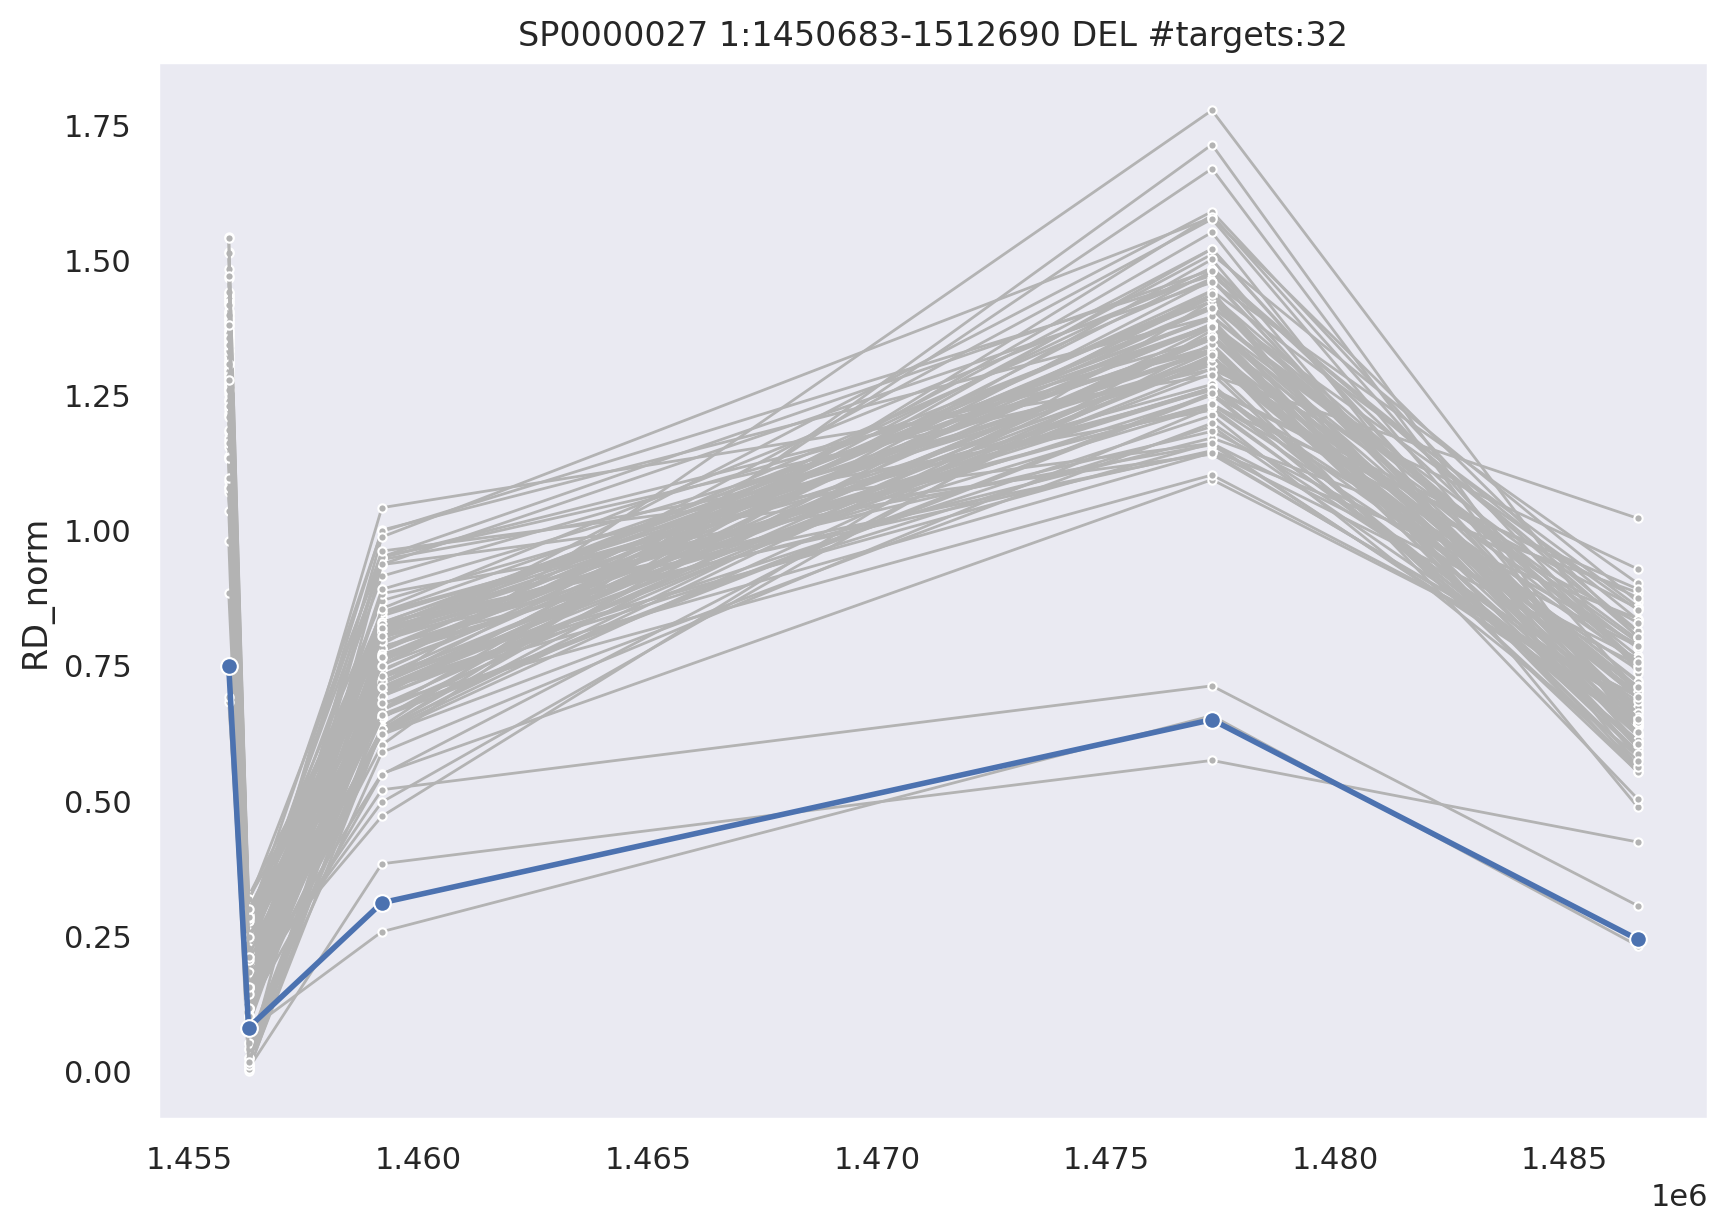

In [92]:
## Generate images
title_info = sampleID+" "+str(cnv_chr)+":"+str(cnv_start)+"-"+str(cnv_end)+" "+cnv_type+ " #targets:"+str(cnv_num_targets)
image_file = str(index+1)+"_"+sampleID+"_"+str(cnv_chr)+"_"+str(cnv_start)+"_"+str(cnv_end)+"_"+cnv_type+ "_"+str(cnv_num_targets)+"tgs.png"
plt.figure(dpi=200,figsize=(10, 7)) 
sns.set_theme(style="dark")
sns.lineplot(data=reference_RD_df, x=(reference_RD_df["start"]+reference_RD_df["end"])/2, 
             y="RD_norm", units="sample",color='0.7', estimator=None, marker='.', linewidth=1)
palette = sns.color_palette("mako_r", 1)
sns.lineplot(data=RD_cnv_region, x=(RD_cnv_region["start"]+RD_cnv_region["end"])/2, 
             y="RD_norm", marker='o', linewidth=2).set_title(title_info)
#plt.savefig(output_image_dir+image_file)
print(title_info)
#plt.close()

In [24]:
cnv_data_df[:1].shape()

(1, 18)

In [556]:
for index, row in cnv_data_df.iterrows(): 
    if index > 100:
        break
    sampleID  = row[col_sampleID]
    cnv_chr   = row[col_cnv_chr]
    cnv_start = np.int(row[col_cnv_start])
    cnv_end   = np.int(row[col_cnv_end])
    cnv_type  = row[col_cnv_type]
    cnv_num_targets = row[col_cnv_num_targets]
    cnv_label = row[col_cnv_label]
    if cnv_label == 0:
        output_image_dir = output_false_image_dir
    elif cnv_label == 1: 
        output_image_dir = output_true_image_dir
    else:
        print("cnv_label error?", cnv_label)
        pdb.set_trace()
        
    print("Illustrating: ", index+1,"_____", sampleID, cnv_chr, cnv_start, cnv_end, cnv_type,cnv_num_targets)
    
    ## Import RD data info
    RD_norm_data = loadNormRD(RD_norm_dir, sampleID)
    print("[Step1] Loaded normalized RD for %s, there are %d #windows of RD signal."%(sampleID, len(RD_norm_data)))

    ## Fetch Read depth data for case sample in terms of CNV boundary
    RD_cnv_region = fetchRDdata(RD_norm_data, cnv_chr, cnv_start, cnv_end)
    print("[Step2] Fetched %d capture windows based on CNV boundary."%len(RD_cnv_region))
    
    ## Fetch Read depth data for reference samples in terms of CNV boundary
    reference_RD_df = fetchRefRDdata(ref_samples_dir, sampleID, cnv_chr, cnv_start, cnv_end)
    print("[Step3] Fetched RD data for reference samples.")

    ## Generate images
    title_info = sampleID+" "+str(cnv_chr)+":"+str(cnv_start)+"-"+str(cnv_end)+" "+cnv_type+ " #targets:"+str(cnv_num_targets)
    image_file = str(index+1)+"_"+sampleID+"_"+str(cnv_chr)+"_"+str(cnv_start)+"_"+str(cnv_end)+"_"+cnv_type+ "_"+str(cnv_num_targets)+"tgs.png"
    plt.figure(dpi=200,figsize=(10, 7)) 
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=reference_RD_df, x=(reference_RD_df["start"]+reference_RD_df["end"])/2, 
                 y="RD_norm", units="sample",color=".7", estimator=None, marker='.', linewidth=1)
    sns.lineplot(data=RD_cnv_region, x=(RD_cnv_region["start"]+RD_cnv_region["end"])/2, 
                 y="RD_norm", marker='o', linewidth=2).set_title(title_info)
    plt.savefig(output_image_dir+image_file)
    print(title_info)
    plt.close()
    print("______________________________________________________")

Illustrating:  SP0000027 1 1450683 1512690 DEL 32
[Step1] Loaded normalized RD for SP0000027, there are 214408 #windows of RD signal.
[Step2] Fetched 32 capture windows based on CNV boundary.
[Step3] Fetched RD data for reference samples.
SP0000027 1:1450683-1512690 DEL #targets:32
Illustrating:  SP0000027 19 46120329 46124649 DEL 4
[Step1] Loaded normalized RD for SP0000027, there are 214408 #windows of RD signal.
[Step2] Fetched 4 capture windows based on CNV boundary.
[Step3] Fetched RD data for reference samples.
SP0000027 19:46120329-46124649 DEL #targets:4
Illustrating:  SP0000027 11 95835289 95923954 DUP 17
[Step1] Loaded normalized RD for SP0000027, there are 214408 #windows of RD signal.
[Step2] Fetched 17 capture windows based on CNV boundary.
[Step3] Fetched RD data for reference samples.
SP0000027 11:95835289-95923954 DUP #targets:17
Illustrating:  SP0000027 12 7869862 7936037 DUP 17
[Step1] Loaded normalized RD for SP0000027, there are 214408 #windows of RD signal.
[Step2]